In [2]:
%env CUDA_VISIBLE_DEVICES=1
import torch, torchvision
import method
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=1


In [3]:
from skimage.io import imread
from skimage.transform import resize
import os

img_batch = []
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = os.listdir('./imnet')

for path in images[:64]:
    try:
        img = imread('./imnet/'+path).transpose((2, 0, 1))
        img = resize(img, (3, 224, 224)).astype(float)
        img -= mean[:, None, None]
        img /= std[:, None, None]
        img_batch.append(img.copy())
    except:
        pass

img_batch = np.array(img_batch)

In [4]:
d = torch.device('cuda')
net = torchvision.models.resnet34(pretrained=True)
net.to(d);

In [5]:
model = method.ResNetWrapper(net, d)

In [6]:
x = torch.randn(3 * 224**2, requires_grad=True).to(d)
x_img = x.reshape((1, 3, 224, 224))

In [7]:
img_batch = np.load('img_batch.npy')

In [26]:
Adot, ATdot = method.get_batched_matvec(img_batch, model, 6, model.feature(x_img, 6).shape[0])

In [30]:
x0 = (np.random.rand(3 * 224**2) - 0.5) / 255.
x, s = method.power_method(x0, Adot, ATdot,  np.inf, 10, max_iter=10)

(-0.5, 223.5, 223.5, -0.5)

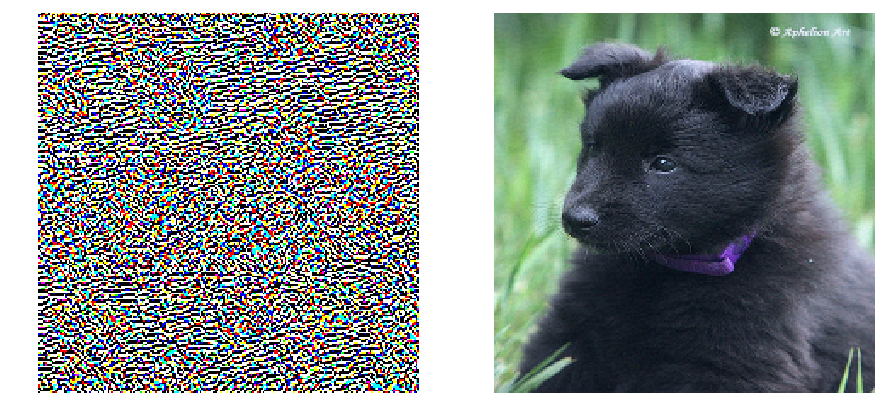

In [31]:
plt.figure(figsize=(15, 8))
adv = x.reshape(3, 224, 224) * 0.04
adv1 = (adv - adv.min())/(adv.max() - adv.min())
plt.subplot(1, 2, 1)
plt.imshow(adv1.transpose((1, 2, 0)))
plt.axis('off')

plt.subplot(1, 2, 2)
adv1 = (img + adv)
adv1 = (adv1 - adv1.min())/(adv1.max() - adv1.min())
plt.imshow(adv1.transpose((1, 2, 0)))
plt.axis('off')

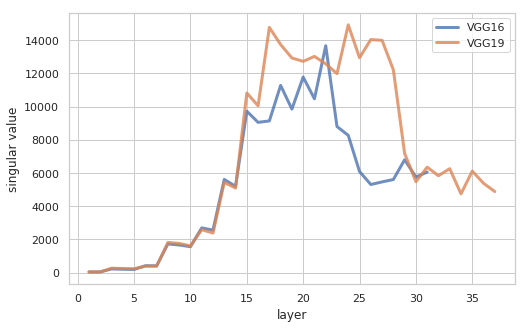

In [3]:
plt.figure(figsize=(8, 5))
results = [
    ('./vgg16-res.npy', 'VGG16'),
    ('./vgg19-res.npy', 'VGG19'),
#     ('./resnet34-res.npy', 'ResNet34')
]
for fname, title in results:
    x = np.load(fname)
    plt.plot(x[:, 0], x[:, 1], label=title, lw=3, alpha=.8)
plt.legend()
plt.xlabel('layer')
plt.ylabel('singular value')
plt.savefig('vgg-singularvalues-plot.png', dpi=300, bbox_inches='tight')